# Neural Network
## importing files and data

In [188]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from tensorboard.plugins.hparams import api as hp
import datetime
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from keras.callbacks import EarlyStopping
tfd = tfp.distributions
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [66]:
def calculate_biweight_outlier_rate(z_photo,z_spec,b_bw,sigma_bw):
    
# The biweight outlier rate defined in HSC DPR2 paper. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz-b_bw)>2*sigma_bw)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv
    

In [68]:
def calculate_conv_outlier_rate(z_photo,z_spec):

# This function calculate the conventional outlier rate. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz)>0.15)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv

In [189]:
photozdata = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')

spectro_z = np.asarray(photozdata["specz_redshift"])
col1 = np.asarray(photozdata["g_cmodel_mag"])
col2 = np.asarray(photozdata["r_cmodel_mag"])
col3 = np.asarray(photozdata["i_cmodel_mag"])
col4 =np.asarray(photozdata["z_cmodel_mag"])
col5 = np.asarray(photozdata["y_cmodel_mag"])


photodata = {'col1':col1,
             'col2':col2,
             'col3':col3,
             'col4':col4,
             'col5':col5,
             'specz':spectro_z
}


df = pd.DataFrame(photodata)
photodata = df

photodata.replace(-99., np.nan, inplace=True)
photodata.replace(-99.9, np.nan, inplace=True)
photodata.replace(np.inf, np.nan, inplace=True)
photodata= photodata.dropna(how='any')
spectro_z = photodata['specz']
photodata = photodata.drop("specz", axis=1)



#normalize
photodata = min_max_scaler.fit_transform(photodata)



In [30]:
photozdata

,object_id,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec,specz_flag_homogeneous,ra,dec,...,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma
0,42278833428106463,0.000110,0.548910,19.242001,DEEP3-201701-11013115,213.522460,-0.036944,True,213.522449,-0.036943,...,20.979572,19.947130,19.067715,18.589880,18.398716,0.003210,0.001870,0.001047,0.001360,0.002279
1,42278695989150320,0.000150,0.548210,19.582001,DEEP3-201701-11013116,213.619030,-0.088530,True,213.619050,-0.088552,...,21.935928,20.279877,19.297018,18.870232,18.658607,0.007159,0.002199,0.001163,0.001322,0.002316
2,41030088866680729,0.000020,0.069250,17.190001,DEEP3-201701-11013724,152.325160,-0.450379,True,152.325150,-0.450388,...,18.288635,17.634911,17.292387,17.095787,16.931446,0.000671,0.000516,0.000366,0.000526,0.001313
3,41117487156191017,0.000120,0.565800,19.165001,DEEP3-201701-11013854,182.709660,-1.001322,True,182.709648,-1.001312,...,22.071690,20.442038,19.342354,18.947113,18.757706,0.007152,0.002496,0.001147,0.001388,0.002247
4,41122709836425861,0.000100,0.441510,18.983000,DEEP3-201701-11013857,183.194060,-0.934613,True,183.194018,-0.934595,...,21.944164,20.366680,19.581245,19.234711,19.079449,0.005164,0.002079,0.001041,0.001563,0.002174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286396,74648752102607194,0.000092,0.679413,21.552523,DEEP3-201701-13036186,214.833737,53.040401,True,214.833754,53.040417,...,24.583908,22.849722,21.685707,21.253208,20.991869,0.032730,0.018004,0.004215,0.007365,0.014793
286397,74648752102580829,0.000022,0.744444,23.466902,DEEP3-201701-13036262,214.814122,53.034795,True,214.814130,53.034815,...,24.467262,24.115664,23.644138,23.402760,23.475128,0.029626,0.041195,0.018262,0.046740,0.120181
286398,74648477224684554,0.000041,0.777939,21.767231,DEEP3-201701-13041028,215.289018,53.078565,True,215.288970,53.078577,...,23.475531,22.753321,22.056278,21.713366,21.827911,0.031231,0.040522,0.018400,0.037899,0.115345
286399,74648618958598412,0.000013,0.363510,22.626217,DEEP3-201701-13051550,214.965382,53.137450,True,214.965402,53.137510,...,24.413773,23.312382,22.863266,22.442661,22.421177,0.041090,0.032388,0.019938,0.031696,0.056599


In [185]:
def custom_loss(y_actual,y_pred):
    delz = (y_pred-y_actual)/(1+y_actual)
    denominator = 1 + (delz/0.15)**2
    loss = 1-(1/denominator)
    return loss

## Setting up and training the model

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 400)          2400        input_11[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 400)          160400      dense_50[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 400)          160400      dense_51[0][0]                   
___________________________________________________________________________________________

Epoch 39/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1157 - mean_absolute_error: 0.1250 - val_loss: 0.1201 - val_mean_absolute_error: 0.1264
Epoch 40/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1164 - mean_absolute_error: 0.1252 - val_loss: 0.1150 - val_mean_absolute_error: 0.1247
Epoch 41/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1154 - mean_absolute_error: 0.1248 - val_loss: 0.1185 - val_mean_absolute_error: 0.1252
Epoch 42/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1141 - mean_absolute_error: 0.1236 - val_loss: 0.1116 - val_mean_absolute_error: 0.1213
Epoch 43/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1160 - mean_absolute_error: 0.1252 - val_loss: 0.1189 - val_mean_absolute_error: 0.1296
Epoch 44/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1147 - mean_absolute_error: 0.1244 - val_loss: 0.1113 - val_mean_absolute_error: 0.1207
Epoch 45/500
46/

Epoch 89/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1038 - mean_absolute_error: 0.1167 - val_loss: 0.1034 - val_mean_absolute_error: 0.1148
Epoch 90/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1030 - mean_absolute_error: 0.1161 - val_loss: 0.1067 - val_mean_absolute_error: 0.1194
Epoch 91/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1083 - mean_absolute_error: 0.1196 - val_loss: 0.1078 - val_mean_absolute_error: 0.1195
Epoch 92/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1020 - mean_absolute_error: 0.1150 - val_loss: 0.1003 - val_mean_absolute_error: 0.1138
Epoch 93/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1017 - mean_absolute_error: 0.1150 - val_loss: 0.1061 - val_mean_absolute_error: 0.1168
Epoch 94/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1041 - mean_absolute_error: 0.1167 - val_loss: 0.1008 - val_mean_absolute_error: 0.1128
Epoch 95/500
46/

Epoch 139/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0989 - mean_absolute_error: 0.1126 - val_loss: 0.1016 - val_mean_absolute_error: 0.1172
Epoch 140/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0994 - mean_absolute_error: 0.1131 - val_loss: 0.1044 - val_mean_absolute_error: 0.1152
Epoch 141/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0993 - mean_absolute_error: 0.1130 - val_loss: 0.0988 - val_mean_absolute_error: 0.1119
Epoch 142/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0986 - mean_absolute_error: 0.1124 - val_loss: 0.0990 - val_mean_absolute_error: 0.1120
Epoch 143/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0990 - mean_absolute_error: 0.1125 - val_loss: 0.1004 - val_mean_absolute_error: 0.1139
Epoch 144/500
46/46 [==============================] - 0s 2ms/step - loss: 0.1023 - mean_absolute_error: 0.1153 - val_loss: 0.1056 - val_mean_absolute_error: 0.1166
Epoch 145/

Epoch 189/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0966 - mean_absolute_error: 0.1101 - val_loss: 0.0992 - val_mean_absolute_error: 0.1117
Epoch 190/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0971 - mean_absolute_error: 0.1103 - val_loss: 0.0970 - val_mean_absolute_error: 0.1096
Epoch 191/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0956 - mean_absolute_error: 0.1088 - val_loss: 0.1021 - val_mean_absolute_error: 0.1142
Epoch 192/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0997 - mean_absolute_error: 0.1122 - val_loss: 0.0957 - val_mean_absolute_error: 0.1079
Epoch 193/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0974 - mean_absolute_error: 0.1105 - val_loss: 0.1028 - val_mean_absolute_error: 0.1123
Epoch 194/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0969 - mean_absolute_error: 0.1100 - val_loss: 0.0981 - val_mean_absolute_error: 0.1100
Epoch 195/

Epoch 239/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0956 - mean_absolute_error: 0.1090 - val_loss: 0.0959 - val_mean_absolute_error: 0.1087
Epoch 240/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0951 - mean_absolute_error: 0.1081 - val_loss: 0.0971 - val_mean_absolute_error: 0.1095
Epoch 241/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0961 - mean_absolute_error: 0.1089 - val_loss: 0.0943 - val_mean_absolute_error: 0.1069
Epoch 242/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0943 - mean_absolute_error: 0.1075 - val_loss: 0.0983 - val_mean_absolute_error: 0.1082
Epoch 243/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0952 - mean_absolute_error: 0.1082 - val_loss: 0.0968 - val_mean_absolute_error: 0.1116
Epoch 244/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0955 - mean_absolute_error: 0.1083 - val_loss: 0.1015 - val_mean_absolute_error: 0.1135
Epoch 245/

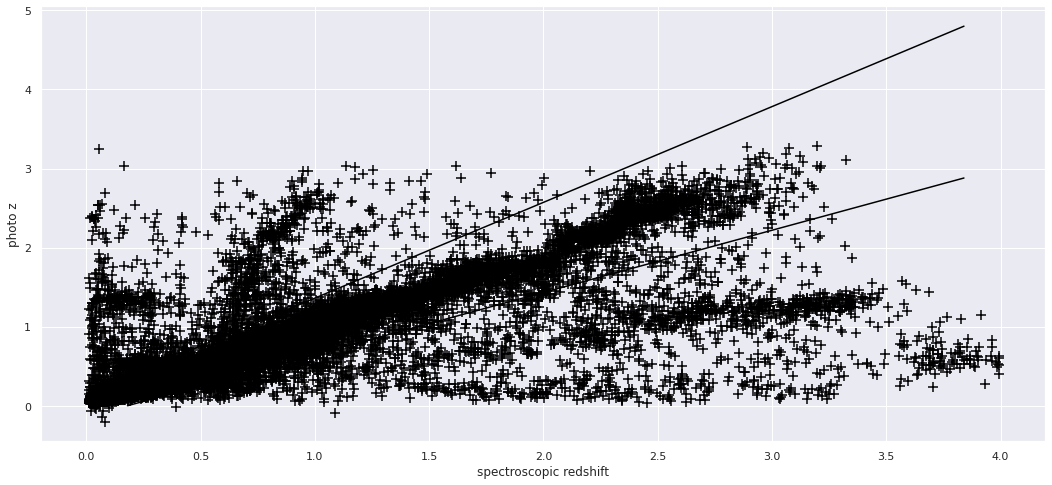

In [190]:
x_train ,x_test,y_train,y_test = train_test_split(photodata,spectro_z,test_size=0.2)

y_test_original = np.array(y_test)
x_train = np.array(x_train)
x_test = np.array(x_test)

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= 0.0000001*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

input_ = tf.keras.layers.Input(shape=x_train.shape[1:])
hidden1 = tf.keras.layers.Dense(400, activation="relu")(input_)
hidden2 = tf.keras.layers.Dense(400, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(400, activation="relu")(hidden2)
hidden4 = tf.keras.layers.Dense(400, activation="relu")(hidden3)
concat = tf.keras.layers.Concatenate()([input_, hidden4])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_], outputs=[output])


model.compile(optimizer='adam', loss=custom_loss,metrics=[tf.keras.metrics.MeanAbsoluteError()])


model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience = 20)


history = model.fit(x_train,y_train,batch_size=5000,epochs=500,shuffle = True,verbose=1,validation_data=(x_test,y_test),callbacks=[es])


predictions = model.predict(x_test)
photoz = []
for i in range(0,len(y_test)):
    photoz.append(predictions[i])




num_correct = 0
outliers = []
outlier_index = []
cat_outlier_index = []
for i in range(0,len(y_test)):

  
    outliers.append(abs(photoz[i] - y_test_original[i])/(1+y_test_original[i]))

    if outliers[i] > 0.15:
            outlier_index.append(i)


    if outliers[i] > 1:
            cat_outlier_index.append(i)



print("number of outliers: ", len(outlier_index), " out of ", len(y_test))
print("% of outliers: ", 100.0*len(outlier_index)/len(y_test))
print("number of catastrophic outliers: ", len(cat_outlier_index), " out of ", len(y_test))
print("% of catastrophic outliers: ", len(cat_outlier_index)/len(y_test))




plt.scatter(y_test_original,photoz, marker='+',color = 'black')
#plt.title('Photo-z determination')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')
plt.show()


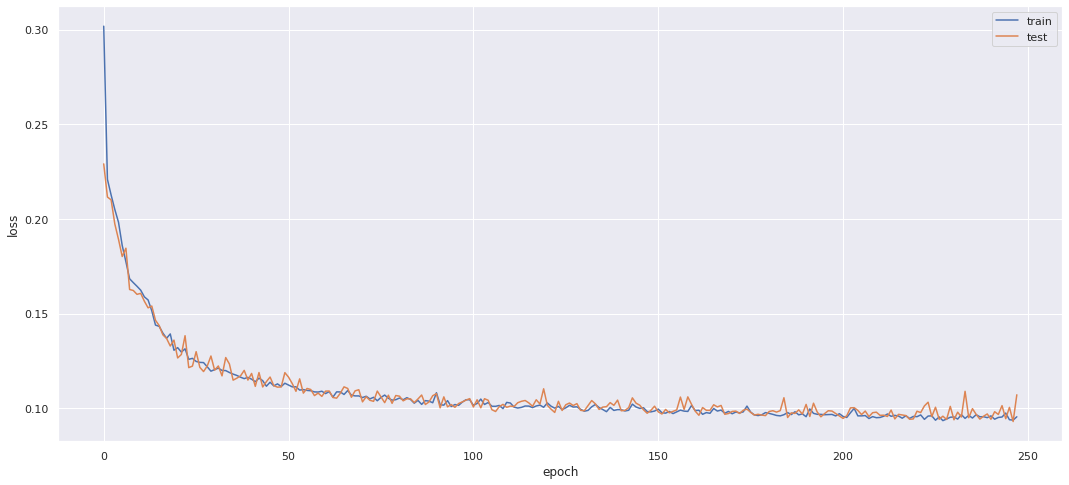

In [193]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [13]:
y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

## Saving results

In [34]:
index = photozdata.index
results = pd.DataFrame(photozdata[["object_id", "specz_redshift","g_cmodel_mag","r_cmodel_mag","i_cmodel_mag",\
                     "z_cmodel_mag","y_cmodel_mag"]])

In [35]:
index_train = y_train.index
index_test = y_test.index

is_in_train = [False]*286401
is_in_test = [False]*286401


for element in index_train:
    is_in_train[element] = True

for element in index_test:
    is_in_test[element] = True   

results["is_in_train"] = is_in_train
results["is_in_test"] = is_in_test

In [138]:
predict = [" "] *286401

i = 0
z = 0
for element in index_train:
    predict[element] = y_train_predict[i][0]
    i+=1

for element in index_test:
    predict[element] = y_test_predict[z][0]
    z +=1

results["predict"] = predict
results

,object_id,specz_redshift,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,is_in_train,is_in_test,predict
0,42278833428106463,0.548910,20.979572,19.947130,19.067715,18.589880,18.398716,True,False,0.572866
1,42278695989150320,0.548210,21.935928,20.279877,19.297018,18.870232,18.658607,True,False,0.518279
2,41030088866680729,0.069250,18.288635,17.634911,17.292387,17.095787,16.931446,False,True,0.082500
3,41117487156191017,0.565800,22.071690,20.442038,19.342354,18.947113,18.757706,True,False,0.562596
4,41122709836425861,0.441510,21.944164,20.366680,19.581245,19.234711,19.079449,True,False,0.463395
...,...,...,...,...,...,...,...,...,...,...
286396,74648752102607194,0.679413,24.583908,22.849722,21.685707,21.253208,20.991869,True,False,0.660454
286397,74648752102580829,0.744444,24.467262,24.115664,23.644138,23.402760,23.475128,True,False,0.779160
286398,74648477224684554,0.777939,23.475531,22.753321,22.056278,21.713366,21.827911,True,False,0.743630
286399,74648618958598412,0.363510,24.413773,23.312382,22.863266,22.442661,22.421177,False,True,0.493632


In [141]:
results.to_csv("~/photoz/results/NN_regression_custom_loss_results_v6.csv")

## Random Forest Model

In [117]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train,y_train)

RandomForestRegressor()

In [118]:
y_train_predict_rf = random_forest_model.predict(x_train)
y_test_predict_rf = random_forest_model.predict(x_test)

## XGBoost

In [194]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [196]:
y_train_predict_xgb = xgb_model.predict(x_train)
y_test_predict_xgb = xgb_model.predict(x_test)

## Evaluating predictions

In [124]:
delz_rf = (y_test_predict_rf - y_test)/(1+y_test)
outlier_index_rf = np.where(abs(delz_rf)>0.15)[0]
outlier_index_rf = index_test[outlier_index_rf]


Int64Index([254285, 187212, 195833, 114437,  93760,  47102, 232137,  26081,
              3085,  93021,
            ...
            195741, 108255,  99325,  21833, 255606, 197706,   6817, 148366,
             19186, 197493],
           dtype='int64', length=5618)

In [198]:
delz_xgb = (y_test_predict_xgb - y_test)/(1+y_test)
outlier_index_xgb = np.where(abs(delz_xgb)>0.15)[0]
outlier_index_xgb = index_test[outlier_index_xgb]

Int64Index([135035, 174826, 187212, 123329, 156543,  73058, 125851,  23245,
            205485, 251272,
            ...
            198722, 202758, 255606, 135838, 156557, 153707, 237921, 261647,
            212012, 266787],
           dtype='int64', length=6456)

In [60]:
y_train_prediction = []
for i in range(len(y_train_predict)):
    y_train_prediction.append(y_train_predict[i][0])
y_train_prediction = np.asarray(y_train_prediction)

y_test_prediction = []
for i in range(len(y_test_predict)):
    y_test_prediction.append(y_test_predict[i][0])
y_test_prediction = np.asarray(y_test_prediction)


In [148]:
delz_nn = (y_test_prediction - y_test)/(1+y_test)
outlier_index_nn = np.where(abs(delz_nn)>0.15)[0]
outlier_index_nn = index_test[outlier_index_nn]



In [204]:
print ("number of outliers for random forest: %s"%(len(outlier_index_rf)))
print ("number of outliers for neural network: %s"%(len(outlier_index_nn)))
print ("number of outliers for XGBoost model: %s"%(len(outlier_index_xgb)))

outlier_index_rf_nn = np.intersect1d(outlier_index_rf,outlier_index_nn)
outlier_index_rf_xgb = np.intersect1d(outlier_index_rf,outlier_index_xgb)
outlier_index_nn_xgb = np.intersect1d(outlier_index_nn,outlier_index_xgb)


outlier_index = np.intersect1d(outlier_index_rf_nn,outlier_index_xgb)

print ("number of common outliers for random forest and neural network: %s" %(len(outlier_index_rf_nn)))
print ("number of common outliers for random forest and XGBoost: %s" %(len(outlier_index_rf_xgb)))
print ("number of common outliers for XGBoost and neural network: %s" %(len(outlier_index_nn_xgb)))

number of outliers for random forest: 5618
number of outliers for neural network: 3698
number of outliers for XGBoost model: 6456
number of common outliers for random forest and neural network: 3097
number of common outliers for random forest and XGBoost: 652
number of common outliers for XGBoost and neural network: 429


In [209]:
photozdata_outlier = photozdata.loc[outlier_index_rf_nn]
photozdata_outlier

,object_id,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec,specz_flag_homogeneous,ra,dec,...,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma
94,42063612616924620,0.000410,3.324370,19.723000,DEEP3-201701-11032752,140.570940,0.344105,True,140.570910,0.344115,...,20.814207,20.253428,19.966248,19.977789,20.022186,0.001821,0.001698,0.000964,0.002329,0.002567
356,40998898814179553,0.000120,0.574700,19.573000,DEEP3-201701-12007890,142.534890,-0.058392,True,142.535123,-0.058266,...,22.865782,23.969234,21.811932,20.955090,23.837084,0.016827,0.072440,0.009898,0.014013,0.571292
410,41130951878659479,0.000320,3.430180,20.861999,DEEP3-201701-11047074,186.911780,-1.201546,True,186.911789,-1.201528,...,21.043993,20.773994,20.732450,20.812187,20.729275,0.002189,0.002055,0.001436,0.002615,0.005718
425,42187178826009953,0.000190,0.655140,20.312000,DEEP3-201701-12020582,181.507230,0.703547,True,181.507242,0.703538,...,21.101105,20.839802,20.545475,20.505505,20.313110,0.002264,0.002580,0.001589,0.002684,0.005809
449,42085735993451127,0.000060,0.623390,19.714001,DEEP3-201701-12003459,147.818160,0.248551,True,147.818140,0.248571,...,20.400055,20.254406,19.910709,19.950481,19.666832,0.001337,0.001242,0.001008,0.002130,0.003517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286308,40625455702738410,0.000305,1.255299,21.816690,SDSS-DR14-9894443964064309248,16.163351,-0.962635,True,16.163365,-0.962620,...,22.551582,21.990471,21.772869,21.582041,21.441059,0.007408,0.005003,0.012101,0.018143,0.013569
286313,41698725080356422,0.000591,2.904666,22.156240,SDSS-DR14-9895720222152695808,17.467890,0.878730,True,17.467893,0.878741,...,23.605587,23.424513,23.580837,23.396835,22.972584,0.013884,0.015052,0.059710,0.116951,0.050095
286332,74649014095608735,0.000007,0.434581,22.124910,DEEP3-201701-11051636,214.226304,52.387534,True,214.226209,52.387531,...,22.914845,22.494867,21.977682,21.720375,22.003960,0.013416,0.015866,0.009414,0.022208,0.049949
286384,74648477224681812,0.000044,0.464190,22.915167,DEEP3-201701-13024537,215.254587,52.968421,True,215.254599,52.968412,...,24.242365,23.328974,23.003252,22.348762,22.203295,0.037742,0.026759,0.024676,0.042621,0.092766


In [89]:
g_mag_test = col1[index_test]
y_mag_test = col5[index_test]
color = g_mag_test - y_mag_test
y_test = np.asarray(y_test)

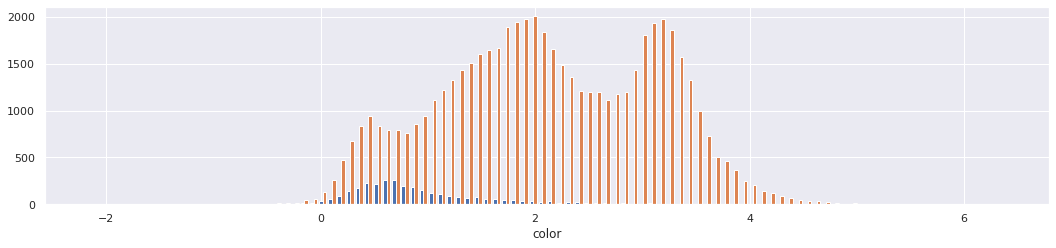

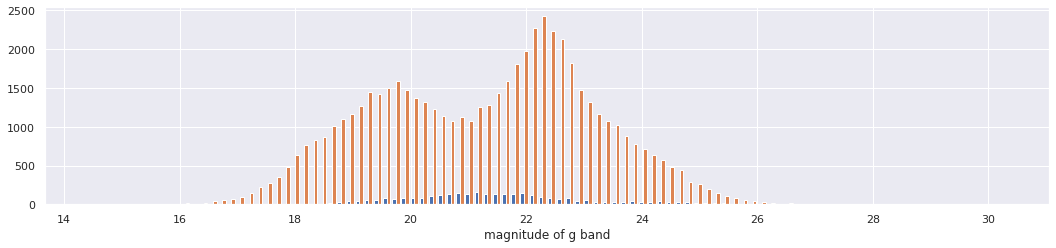

In [211]:
g_mag_outlier = photozdata_outlier["g_cmodel_mag"]
y_mag_outlier = photozdata_outlier["y_cmodel_mag"]
color_outlier = g_mag_outlier - y_mag_outlier
plt.subplot(2,1,1)
plt.hist([color_outlier,color],bins = 100)
plt.xlabel("color")
plt.show()
plt.subplot(2,1,2)
plt.hist([g_mag_outlier,g_mag_test],bins = 100)
plt.xlabel("magnitude of g band")
plt.show()

In [19]:
from photoz_utils import *
print ("testing dataset")
y_test_predict_new = pd.Series(y_test_prediction,index = y_test.index)
get_point_metrics(y_test_predict_new,y_test)

testing dataset


,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",57281,0.098003,-0.004217,-0.003943,0.032347,0.02762,0.145389,0.064559,0.122445


In [20]:
print ("training dataset")
y_train_predict_new = pd.Series(y_train_prediction,index = y_train.index)
get_point_metrics(y_train_predict_new,y_train)

training dataset


,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",229120,0.096018,-0.004198,-0.003991,0.031881,0.027226,0.144475,0.062788,0.117461


In [90]:
print ("color                    bias     sigma_bw     outlier_rate_bw     conv_outlier_rate      <L(delz)>   # of galaxies")


x_list = []
biweight_bias = []
biweight_scatter = []
biweight_outlier = []
loss = []
conv_bias = []
conv_scatter = []
conv_outlier = []

for i in range(15):
    index = np.intersect1d(np.where(color>=0.5*i-2)[0],np.where(color<0.5*i-1.5)[0])
    test_predict_filtered = y_test_prediction[index]
    test_filtered= y_test[index]
    x_list.append(0.5*i-1.75)
    
    
    b_bw = calculate_bias(test_predict_filtered,test_filtered)
    sigma_bw = calculate_scatter(test_predict_filtered,test_filtered)
    outlier_rate = calculate_biweight_outlier_rate(test_predict_filtered,test_filtered,b_bw,sigma_bw)
    loss_function = calculate_loss(test_predict_filtered,test_filtered)
    conv_outlier_rate = calculate_conv_outlier_rate(test_predict_filtered,test_filtered)
    average_loss = sum(loss_function)/len(loss_function)
    
    
    biweight_bias.append(b_bw)
    biweight_scatter.append(sigma_bw)
    biweight_outlier.append(outlier_rate)
    loss.append(average_loss)
    conv_bias.append(calculate_bias(test_predict_filtered,test_filtered,False))
    conv_scatter.append(calculate_scatter(test_predict_filtered,test_filtered,False))
    conv_outlier.append(conv_outlier_rate)

    print ("%+f - %+f   %+f   %.3f            %.3f              %.3f              %.3f         %s"%(0.5*i-2,round(0.5*i-1.5,2),round(b_bw,3),round(sigma_bw,3),round(outlier_rate,3),round(conv_outlier_rate,3),round(average_loss,3),len(test_filtered)))

color                    bias     sigma_bw     outlier_rate_bw     conv_outlier_rate      <L(delz)>   # of galaxies
-2.000000 - -1.500000   +0.895000   0.432            0.000              1.000              0.950         2
-1.500000 - -1.000000   +1.056000   0.822            0.000              0.667              0.660         3
-1.000000 - -0.500000   +0.177000   0.602            0.000              0.688              0.604         16
-0.500000 - +0.000000   +0.008000   0.125            0.292              0.357              0.367         168
+0.000000 - +0.500000   +0.000000   0.065            0.264              0.250              0.278         3395
+0.500000 - +1.000000   -0.001000   0.074            0.296              0.295              0.314         4870
+1.000000 - +1.500000   -0.003000   0.044            0.149              0.087              0.129         7953
+1.500000 - +2.000000   -0.006000   0.036            0.104              0.031              0.075         10820
+2.000000 - 

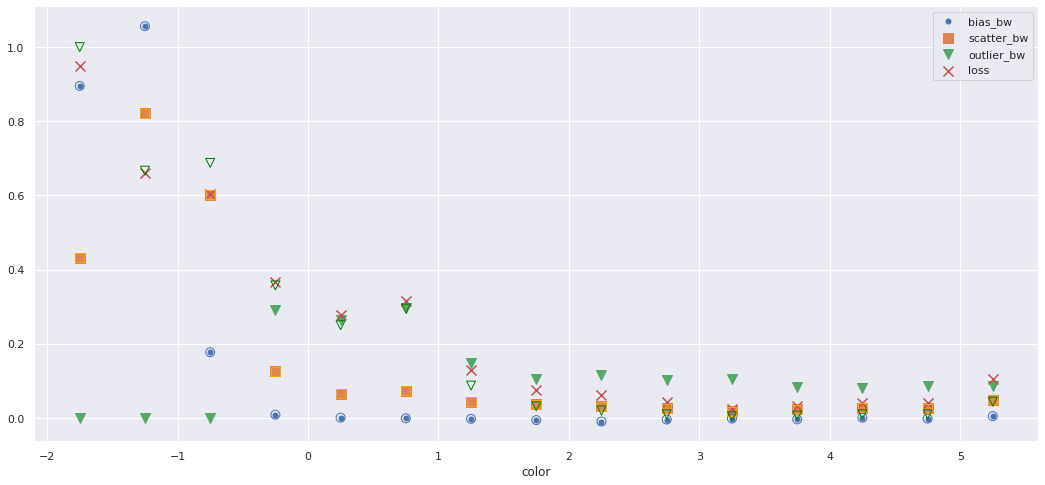

In [212]:
plt.scatter(x_list,biweight_bias,marker = ".",label = "bias_bw")
plt.scatter(x_list,biweight_scatter, marker = "s",label = "scatter_bw")
plt.scatter(x_list,biweight_outlier, marker = "v", label = "outlier_bw")
plt.scatter(x_list,loss, marker = "x", label = "loss")
plt.scatter(x_list,conv_bias,s=80, facecolors='none', edgecolors='b')
plt.scatter(x_list,conv_scatter,marker = "s",edgecolors = 'orange',facecolors = 'none',s = 80)
plt.scatter(x_list,conv_outlier,marker = "v",edgecolors = 'green',facecolors = 'none',s = 80)

plt.legend()
plt.rcParams["figure.figsize"] = (18,8)
plt.gca().yaxis.grid(True)
plt.xlabel("color")
plt.show()

In [25]:
binned_metrics = get_point_metrics(y_test_predict_new,y_test,binned = True)
binned_metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 0.2]",13416,0.073608,-0.003789,-0.003231,0.030090,0.027118,0.106664,0.039356,0.069229
1,"(0.2, 0.4]",10357,0.077485,-0.009801,-0.008583,0.034249,0.027192,0.120015,0.030511,0.017707
2,"(0.4, 0.6]",13698,0.048606,-0.001232,-0.001201,0.021831,0.017883,0.134545,0.021536,0.016480
3,"(0.6, 0.8]",9156,0.088917,-0.004765,-0.004179,0.032209,0.028934,0.125164,0.056029,0.055027
4,"(0.8, 1.0]",3732,0.133890,-0.002443,-0.000659,0.036810,0.032763,0.168542,0.101822,0.146075
5,"(1.0, 1.2]",1506,0.196408,-0.001304,0.000113,0.062735,0.054698,0.172643,0.148074,0.178318
6,"(1.2, 1.4]",986,0.197838,-0.006834,-0.008296,0.056563,0.051823,0.189655,0.171400,0.145062
7,"(1.4, 1.6]",617,0.260558,-0.010587,-0.016275,0.090327,0.075831,0.194489,0.215559,0.213635
8,"(1.6, 1.8]",497,0.242021,0.012961,0.005010,0.071396,0.058975,0.229376,0.221328,0.225599
9,"(1.8, 2.0]",489,0.256269,-0.035191,-0.039713,0.074598,0.060008,0.214724,0.220859,0.278502


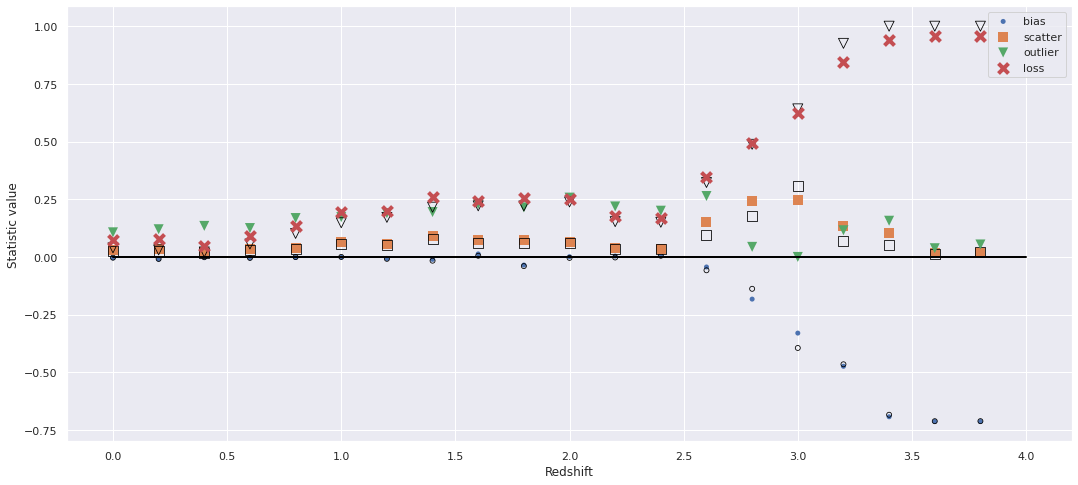

In [26]:
plot_point_metrics(binned_metrics)

In [57]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_test,y_test_prediction])
z = gaussian_kde(xy)(xy)

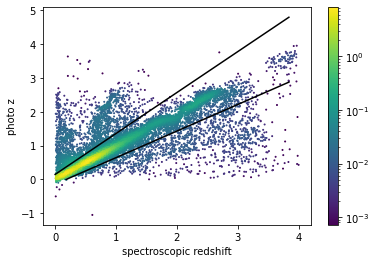

In [58]:
import matplotlib.cm as cm
import matplotlib
fig, ax = plt.subplots()
ax_ = ax.scatter(y_test, y_test_predict, c=z,s = 1,edgecolor=None, norm=matplotlib.colors.LogNorm())
plt.colorbar(ax_)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')